In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/climate-change-edsa2020-21/train.csv
/kaggle/input/climate-change-edsa2020-21/test.csv
/kaggle/input/climate-change-edsa2020-21/sample_submission.csv


In [2]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# **Load and clean data**

In [3]:
df = pd.read_csv('/kaggle/input/climate-change-edsa2020-21/train.csv')
df_test = pd.read_csv('/kaggle/input/climate-change-edsa2020-21/test.csv')

In [4]:
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [5]:
len(df) #number of tweets

15819

In [6]:
print(df['message'][15816])

notiven: RT: nytimesworld :What does Trump actually believe about climate change? Rick Perry joins other aides in … https://t.co/0Mp2


In [7]:
neutral_news = df[(df['sentiment'] == 2) | (df['sentiment'] == 0)].index


In [8]:
df.drop(neutral_news, inplace = True) 

In [9]:
len(df)

9826

In [10]:
df.sentiment.value_counts() #distribution of pro to anti sentiments *BALANCE

 1    8530
-1    1296
Name: sentiment, dtype: int64

In [11]:
type(df)

pandas.core.frame.DataFrame

In [12]:
#check for missing values
df.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [13]:
df_test.isnull().sum()

message    0
tweetid    0
dtype: int64

In [14]:
df.dropna(inplace=True)

In [15]:
df.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [16]:
#remove empty strings
blanks = []

for i,snt,msg, twid in df.itertuples():
    if msg.isspace():
        blanks.append(i) #returns index positions for where there is empty string in message col


In [17]:
blanks

[]

In [18]:
df.drop(blanks, inplace = True)

In [19]:
len(df) 

9826

In [20]:
#remove empty strings
blanks_test = []

for i,msg, twid in df_test.itertuples():
    if msg.isspace():
        blanks_test.append(i) #returns index positions for where there is empty string in message col


In [21]:
blanks_test

[]

In [22]:
df.drop(blanks_test, inplace = True)

Modelling

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X = df['message']
y = df['sentiment']
#y = df[:][['sentiment']]

In [25]:
X.shape

(9826,)

In [26]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, stop_words="english")
X_vectorized = vectorizer.fit_transform(X)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_vectorized, y,test_size=0.3, shuffle=True, stratify=y, random_state =17)

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

In [29]:
text_clf = Pipeline([('clf', LinearSVC())])

In [30]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('clf', LinearSVC())])

In [31]:
predictions = text_clf.predict(X_val)

In [32]:
predictions

array([ 1, -1,  1, ...,  1, -1, -1])

# Checking the performance of our model on the validation set****

In [33]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [34]:
print(confusion_matrix(y_val, predictions))

[[ 186  203]
 [  28 2531]]


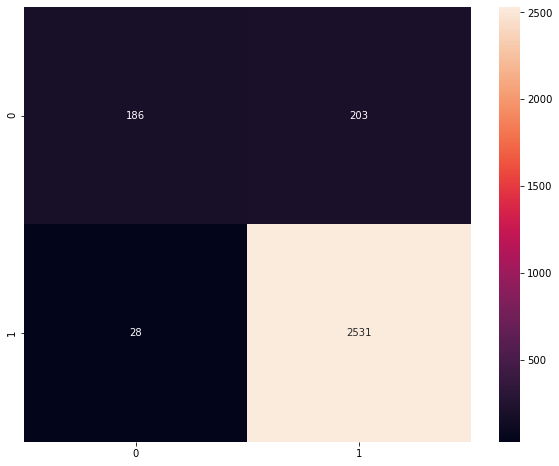

In [35]:
import seaborn as sns
from matplotlib import pyplot as plt
cf_matrix = confusion_matrix(y_val, predictions)
plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [36]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

          -1       0.87      0.48      0.62       389
           1       0.93      0.99      0.96      2559

    accuracy                           0.92      2948
   macro avg       0.90      0.73      0.79      2948
weighted avg       0.92      0.92      0.91      2948



In [37]:
f1_score(y_val, predictions, average="macro")

0.7866364380628503

In [38]:
print(accuracy_score(y_val, predictions))

0.9216417910447762


**Getting our test set ready**

In [39]:
test_x = df_test['message']
test_vect = vectorizer.transform(test_x)

**Making predictions on the test set and adding a sentiment column to our original test df**

In [40]:
y_pred = text_clf.predict(test_vect)

In [41]:
df_test['sentiment'] = y_pred

In [42]:
df_test.head()

,message,tweetid,sentiment
0,Europe will now be looking to China to make su...,169760,1
1,Combine this with the polling of staffers re c...,35326,1
2,"The scary, unimpeachable evidence that climate...",224985,1
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,1
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,1


**Creating an output csv for submission**

In [43]:
df_test[['tweetid','sentiment']].to_csv('testsubmission_SVC.csv', index=False)